In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/MyDrive/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


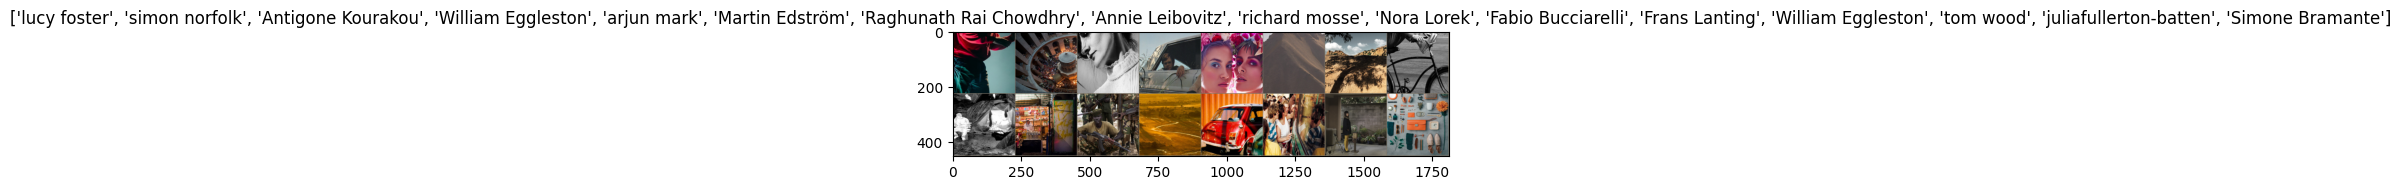

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    #best_model_wts = copy.deepcopy(model_.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=14):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 48)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


 74%|███████▍  | 152/205 [13:09<04:12,  4.77s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [17:29<00:00,  5.12s/it]


train Loss: 3.4059 Acc: 0.1556


100%|██████████| 51/51 [01:47<00:00,  2.12s/it]


test Loss: 2.9548 Acc: 0.2284

Epoch 1/9
----------


 84%|████████▍ | 172/205 [14:15<02:42,  4.93s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [16:48<00:00,  4.92s/it]


train Loss: 2.5131 Acc: 0.3531


100%|██████████| 51/51 [01:37<00:00,  1.90s/it]


test Loss: 2.5558 Acc: 0.2988

Epoch 2/9
----------


 59%|█████▉    | 121/205 [10:00<06:44,  4.82s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [16:47<00:00,  4.91s/it]


train Loss: 2.1433 Acc: 0.4334


100%|██████████| 51/51 [01:42<00:00,  2.01s/it]


test Loss: 2.4607 Acc: 0.3284

Epoch 3/9
----------


 94%|█████████▍| 193/205 [16:04<00:59,  4.94s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [16:55<00:00,  4.95s/it]


train Loss: 1.8639 Acc: 0.5005


100%|██████████| 51/51 [01:43<00:00,  2.03s/it]


test Loss: 2.2988 Acc: 0.3938

Epoch 4/9
----------


  0%|          | 0/205 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [16:54<00:00,  4.95s/it]


train Loss: 1.6842 Acc: 0.5400


100%|██████████| 51/51 [01:41<00:00,  1.99s/it]


test Loss: 2.3338 Acc: 0.3728

Epoch 5/9
----------


  0%|          | 0/205 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [16:53<00:00,  4.94s/it]


train Loss: 1.5420 Acc: 0.5730


100%|██████████| 51/51 [01:47<00:00,  2.11s/it]


test Loss: 2.3843 Acc: 0.3852

Epoch 6/9
----------


 37%|███▋      | 75/205 [06:18<10:42,  4.95s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [16:58<00:00,  4.97s/it]


train Loss: 1.4156 Acc: 0.6034


100%|██████████| 51/51 [01:41<00:00,  1.99s/it]


test Loss: 2.3533 Acc: 0.3852

Epoch 7/9
----------


 95%|█████████▍| 194/205 [16:17<00:52,  4.73s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [17:03<00:00,  4.99s/it]


train Loss: 1.2335 Acc: 0.6625


100%|██████████| 51/51 [01:43<00:00,  2.03s/it]


test Loss: 2.1998 Acc: 0.4222

Epoch 8/9
----------


 57%|█████▋    | 116/205 [09:43<07:23,  4.99s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [17:01<00:00,  4.98s/it]


train Loss: 1.1676 Acc: 0.6894


100%|██████████| 51/51 [01:44<00:00,  2.04s/it]


test Loss: 2.1876 Acc: 0.4296

Epoch 9/9
----------


 22%|██▏       | 46/205 [03:52<13:19,  5.03s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [16:56<00:00,  4.96s/it]


train Loss: 1.1551 Acc: 0.6904


100%|██████████| 51/51 [01:50<00:00,  2.16s/it]

test Loss: 2.2311 Acc: 0.4173

Training complete in 187m 9s
Best test Acc: 0.429630


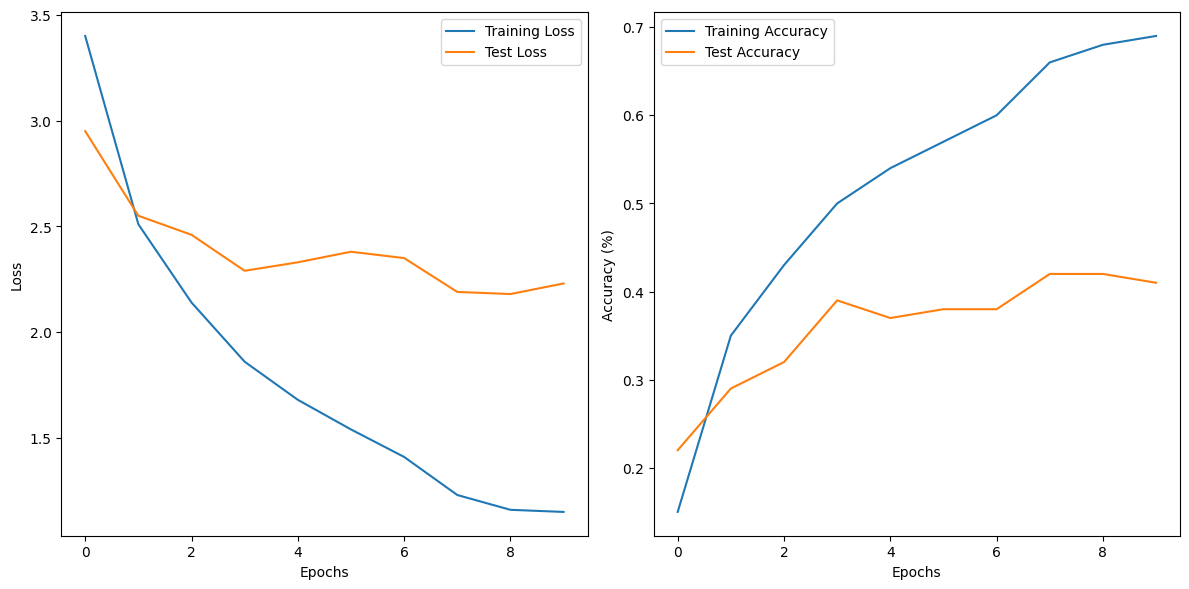

In [ ]:
import matplotlib.pyplot as plt

# Example data for losses and accuracies
training_losses = [3.40, 2.51, 2.14, 1.86, 1.68, 1.54, 1.41, 1.23, 1.16, 1.15]
test_losses = [2.95, 2.55, 2.46, 2.29, 2.33, 2.38, 2.35, 2.19, 2.18, 2.23]
training_accuracies = [0.15,0.35,0.43,0.50,0.54,0.57,0.60,0.66,0.68,0.69]
test_accuracies = [0.22,0.29,0.32,0.39,0.37,0.38,0.38,0.42,0.42,0.41]

# Plotting
plt.figure(figsize=(12, 6))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


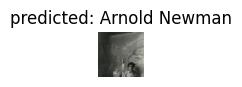

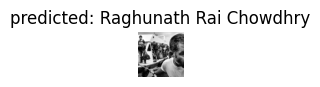

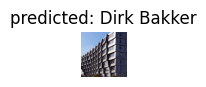

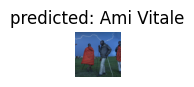

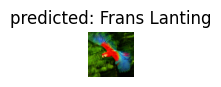

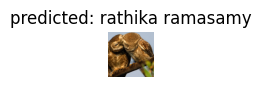

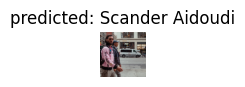

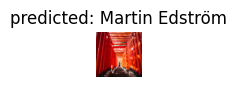

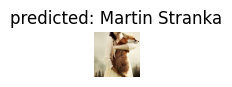

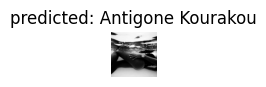

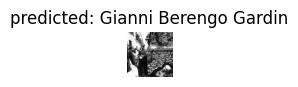

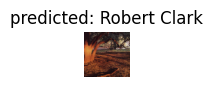

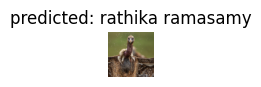

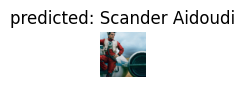

In [ ]:
visualize_model(model_ft)

In [ ]:
!pip install scikit-learn

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


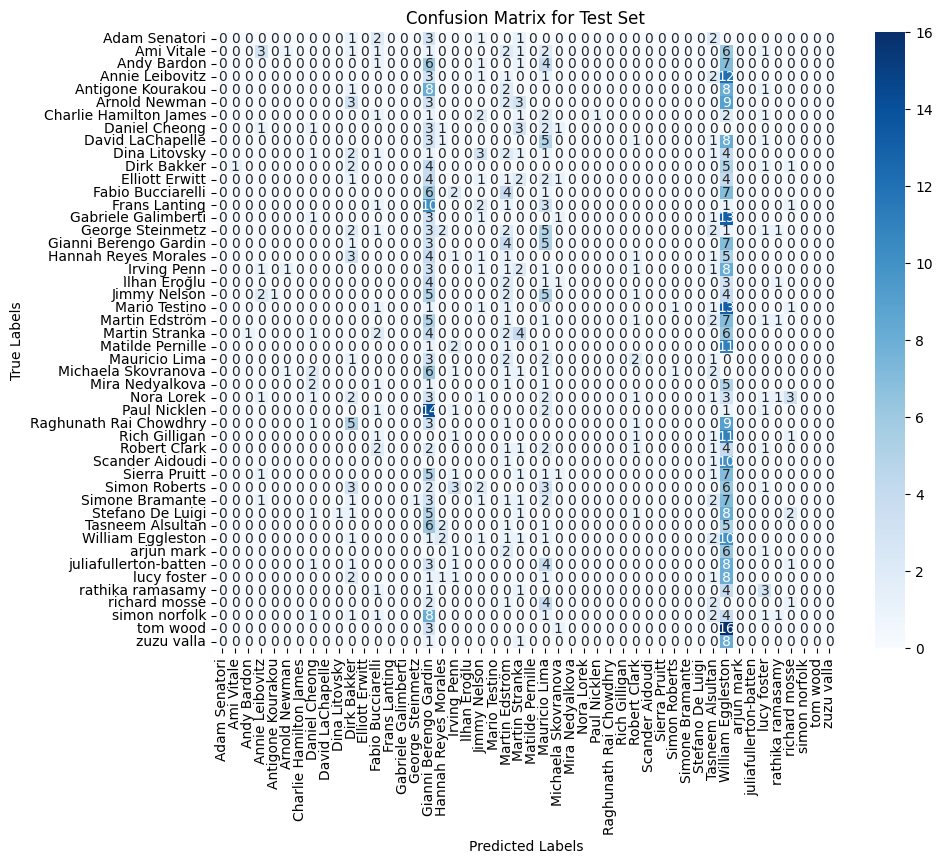

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy

def compute_confusion_matrix(model):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Save confusion matrix to a file
    np.savetxt("resnet34_confusion_matrix.csv", conf_matrix, delimiter=",")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Compute and plot the confusion matrix
compute_confusion_matrix(model_ft)

In [ ]:
import numpy as np
import pandas as pd
import os

# Load confusion matrix CSV (48x48)
cm = np.loadtxt("resnet34_confusion_matrix.csv", delimiter=",")

# Check shape to confirm 48 classes
num_classes = cm.shape[0]
print(f"Confusion matrix shape: {cm.shape}")

if num_classes != 48:
    raise ValueError("Confusion matrix is not 48x48!")

# Replace this with your actual list of 48 class names in correct order
class_names = [
    "Adam Senatori", "Ami Vitale", "Andy Bardon", "Annie Leibovitz", "Antigone Kourakou",
    "Arnold Newman", "Charlie Hamilton James", "Daniel Cheong", "David LaChapelle", "Dina Litovsky",
    "Dirk Bakker", "Elliott Erwitt", "Fabio Bucciarelli", "Frans Lanting", "Gabriele Galimberti",
    "George Steinmetz", "Gianni Berengo Gardin", "Hannah Reyes Morales", "Irving Penn", "İlhan Eroğlu",
    "Jimmy Nelson", "Mario Testino", "Martin Edström", "Martin Stranka", "Matilde Pernille",
    "Mauricio Lima", "Michaela Skovranova", "Mira Nedyalkova", "Nora Lorek", "Paul Nicklen",
    "Raghunath Rai Chowdhry", "Rich Gilligan", "Robert Clark", "Scander Aidoudi", "Sierra Pruitt",
    "Simon Roberts", "Simone Bramante", "Stefano De Luigi", "Tasneem Alsultan", "William Eggleston",
    "Arjun Mark", "Julia Fullerton-Batten", "Lucy Foster", "Rathika Ramasamy", "Richard Mosse",
    "Simon Norfolk", "Tom Wood", "Zuzu Valla"
]

if len(class_names) != 48:
    raise ValueError("class_names list does not contain 48 names!")

# Calculate TP, FP, FN, TN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

# Calculate precision, recall, f1-score
epsilon = 1e-10
precision = TP / (TP + FP + epsilon)
recall = TP / (TP + FN + epsilon)
f1 = 2 * precision * recall / (precision + recall + epsilon)

# Create DataFrame for results
results = pd.DataFrame({
    'Class': class_names,
    'TP': TP,
    'FP': FP,
    'FN': FN,
    'TN': TN,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Set class names as index if you prefer
results.set_index('Class', inplace=True)

# Save to CSV
results.to_csv("class_metrics_resnet34.csv")

# Print first 10 rows to check
print(results.head(48))


Confusion matrix shape: (48, 48)
                          TP     FP    FN     TN  Precision    Recall  \
Class                                                                   
Adam Senatori            0.0    0.0  10.0  800.0   0.000000  0.000000   
Ami Vitale               0.0    1.0  19.0  790.0   0.000000  0.000000   
Andy Bardon              0.0    1.0  20.0  789.0   0.000000  0.000000   
Annie Leibovitz          0.0   10.0  20.0  780.0   0.000000  0.000000   
Antigone Kourakou        0.0    1.0  20.0  789.0   0.000000  0.000000   
Arnold Newman            0.0    3.0  20.0  787.0   0.000000  0.000000   
Charlie Hamilton James   0.0    0.0  11.0  799.0   0.000000  0.000000   
Daniel Cheong            1.0   12.0  11.0  786.0   0.076923  0.083333   
David LaChapelle         0.0    0.0  20.0  790.0   0.000000  0.000000   
Dina Litovsky            0.0    1.0  17.0  792.0   0.000000  0.000000   
Dirk Bakker              2.0   33.0  12.0  763.0   0.057143  0.142857   
Elliott Erwitt    

<Figure size 2200x1000 with 0 Axes>

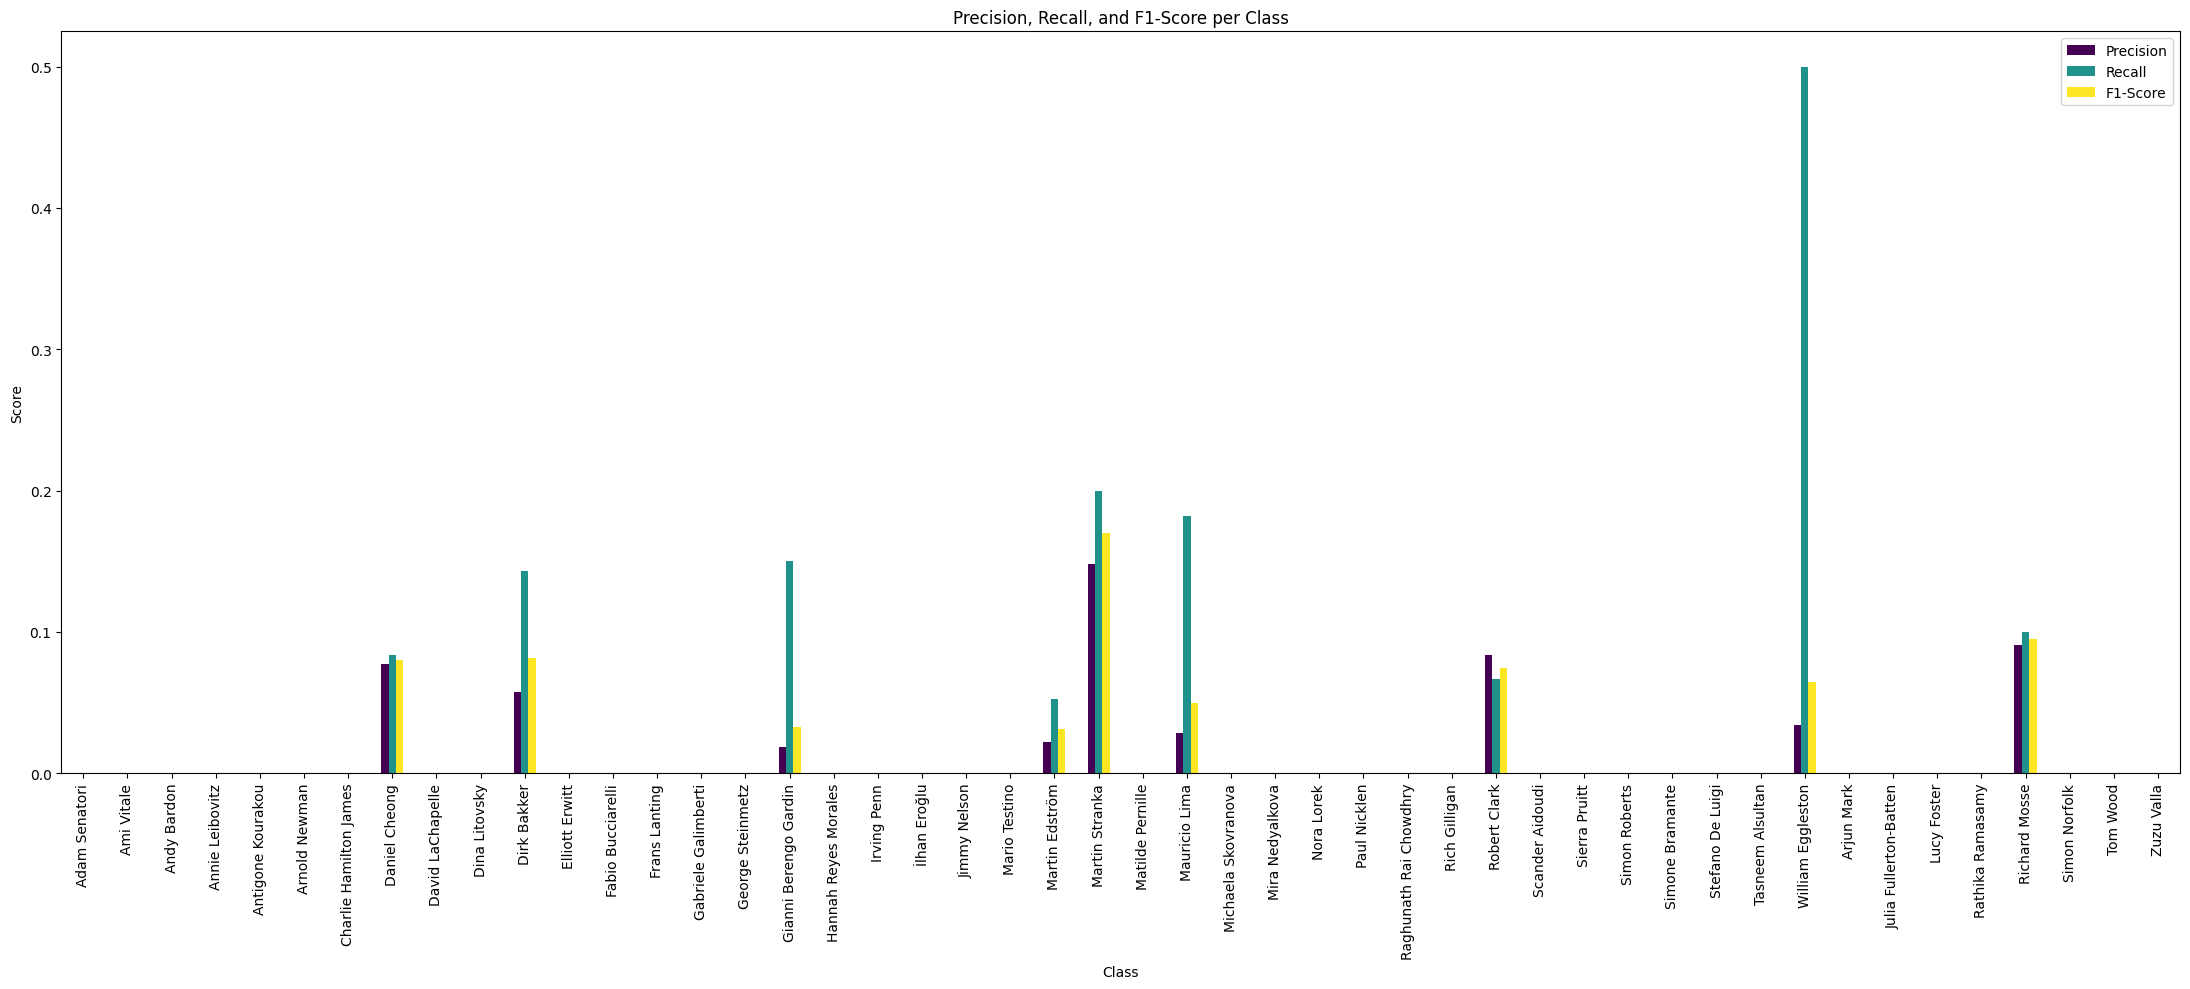

In [ ]:
plt.figure(figsize=(22, 10))
metrics = ['Precision', 'Recall', 'F1-Score']
results_plot = results[metrics]

results_plot.plot(kind='bar', figsize=(22, 10), colormap='viridis')
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score per Class')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 48)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


  0%|          | 0/205 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 65%|██████▌   | 134/205 [05:16<02:51,  2.41s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [07:51<00:00,  2.30s/it]


train Loss: 3.6072 Acc: 0.1078


100%|██████████| 51/51 [01:49<00:00,  2.14s/it]


test Loss: 3.3221 Acc: 0.1494

Epoch 1/9
----------


 54%|█████▎    | 110/205 [04:11<03:53,  2.45s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [07:46<00:00,  2.27s/it]


train Loss: 3.0360 Acc: 0.2435


100%|██████████| 51/51 [01:55<00:00,  2.27s/it]


test Loss: 3.0444 Acc: 0.2049

Epoch 2/9
----------


 68%|██████▊   | 139/205 [05:12<02:10,  1.98s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [07:41<00:00,  2.25s/it]


train Loss: 2.7197 Acc: 0.3118


100%|██████████| 51/51 [01:50<00:00,  2.18s/it]


test Loss: 2.8363 Acc: 0.2556

Epoch 3/9
----------


  8%|▊         | 16/205 [00:40<07:35,  2.41s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [07:50<00:00,  2.29s/it]


train Loss: 2.5051 Acc: 0.3697


100%|██████████| 51/51 [01:50<00:00,  2.16s/it]


test Loss: 2.7490 Acc: 0.2840

Epoch 4/9
----------


 17%|█▋        | 34/205 [01:20<05:15,  1.85s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [07:42<00:00,  2.26s/it]


train Loss: 2.3690 Acc: 0.3966


100%|██████████| 51/51 [01:50<00:00,  2.17s/it]


test Loss: 2.6779 Acc: 0.2827

Epoch 5/9
----------


 18%|█▊        | 36/205 [01:23<05:48,  2.06s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [07:33<00:00,  2.21s/it]


train Loss: 2.2692 Acc: 0.4077


100%|██████████| 51/51 [01:56<00:00,  2.28s/it]


test Loss: 2.6499 Acc: 0.2852

Epoch 6/9
----------


 68%|██████▊   | 139/205 [05:14<02:16,  2.06s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [07:37<00:00,  2.23s/it]


train Loss: 2.1711 Acc: 0.4398


100%|██████████| 51/51 [01:56<00:00,  2.28s/it]


test Loss: 2.5818 Acc: 0.3210

Epoch 7/9
----------


  5%|▍         | 10/205 [00:26<07:01,  2.16s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [07:40<00:00,  2.25s/it]


train Loss: 2.0870 Acc: 0.4609


100%|██████████| 51/51 [01:56<00:00,  2.29s/it]


test Loss: 2.5757 Acc: 0.3198

Epoch 8/9
----------


 14%|█▎        | 28/205 [01:06<05:41,  1.93s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [07:36<00:00,  2.23s/it]


train Loss: 2.0505 Acc: 0.4793


100%|██████████| 51/51 [01:49<00:00,  2.14s/it]


test Loss: 2.5570 Acc: 0.3111

Epoch 9/9
----------


 36%|███▌      | 73/205 [03:01<04:57,  2.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [07:50<00:00,  2.29s/it]


train Loss: 2.0671 Acc: 0.4704


100%|██████████| 51/51 [01:50<00:00,  2.18s/it]


test Loss: 2.5684 Acc: 0.3148

Training complete in 95m 58s
Best test Acc: 0.320988


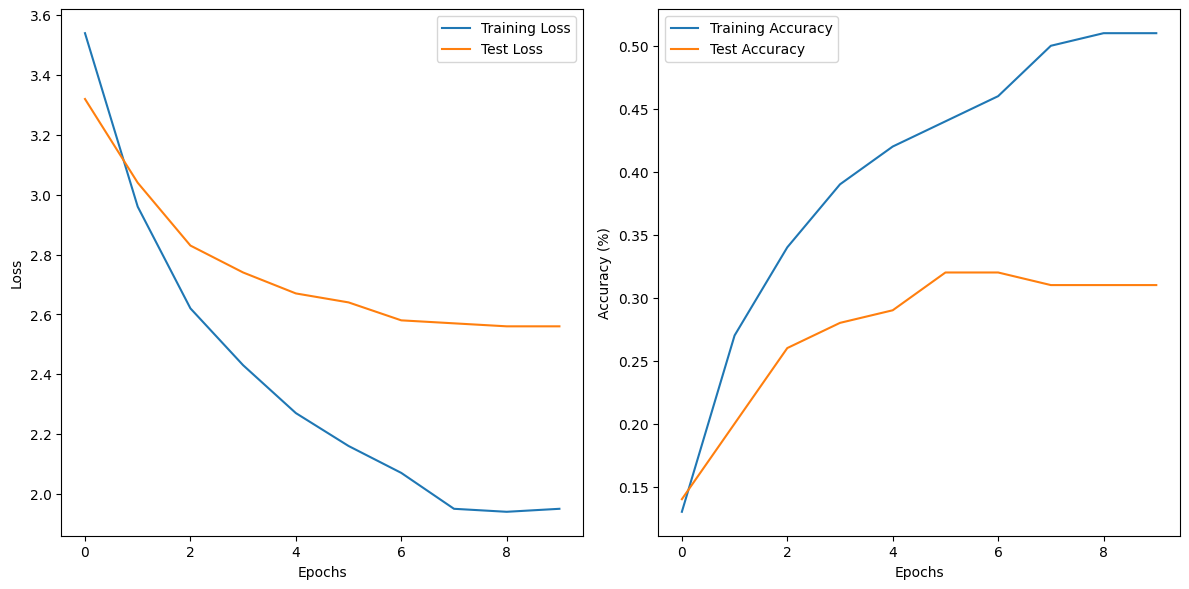

In [ ]:
import matplotlib.pyplot as plt

# Example data for losses and accuracies
training_losses = [3.54,2.96,2.62,2.43,2.27,2.16,2.07,1.95,1.94,1.95]
test_losses = [3.32, 3.04, 2.83, 2.74, 2.67, 2.64, 2.58, 2.57, 2.56, 2.56]
training_accuracies = [0.13,0.27,0.34,0.39,0.42,0.44,0.46,0.50,0.51,0.51,]
test_accuracies = [0.14,0.20,0.26,0.28,0.29,0.32,0.32,0.31,0.31,0.31]

# Plotting
plt.figure(figsize=(12, 6))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


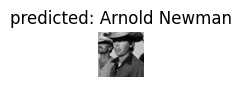

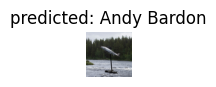

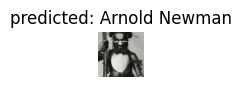

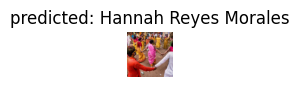

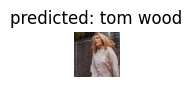

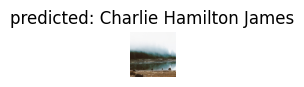

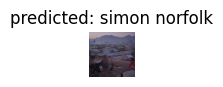

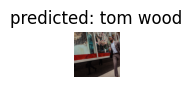

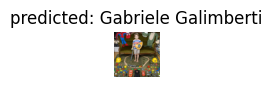

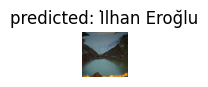

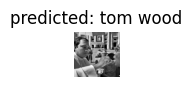

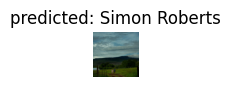

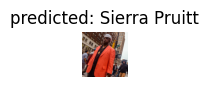

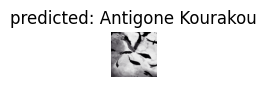

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


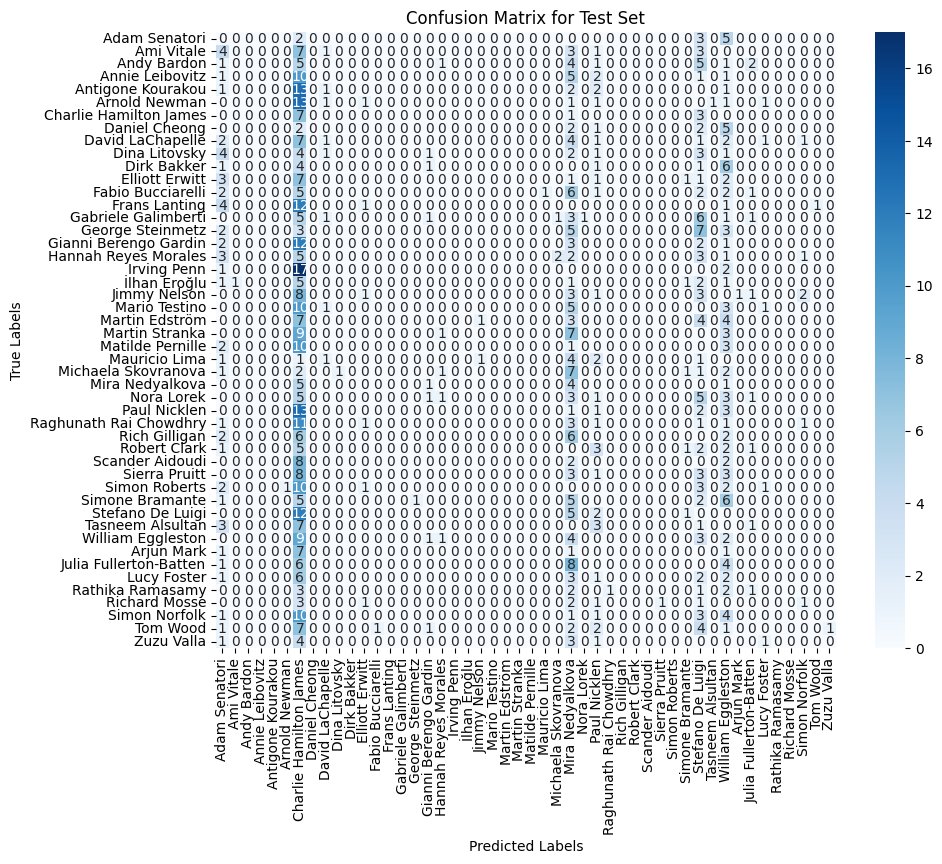

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



def compute_confusion_matrix(model):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    np.savetxt("resnet34_confusion_matrix.csv", conf_matrix, delimiter=",")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Compute and plot the confusion matrix
compute_confusion_matrix(model_conv)


In [ ]:
import numpy as np
import pandas as pd
import os

# Load confusion matrix CSV (48x48)
cm = np.loadtxt("resnet34_confusion_matrix.csv", delimiter=",")

# Check shape to confirm 48 classes
num_classes = cm.shape[0]
print(f"Confusion matrix shape: {cm.shape}")

if num_classes != 48:
    raise ValueError("Confusion matrix is not 48x48!")

# Replace this with your actual list of 48 class names in correct order
class_names = [
    "Adam Senatori", "Ami Vitale", "Andy Bardon", "Annie Leibovitz", "Antigone Kourakou",
    "Arnold Newman", "Charlie Hamilton James", "Daniel Cheong", "David LaChapelle", "Dina Litovsky",
    "Dirk Bakker", "Elliott Erwitt", "Fabio Bucciarelli", "Frans Lanting", "Gabriele Galimberti",
    "George Steinmetz", "Gianni Berengo Gardin", "Hannah Reyes Morales", "Irving Penn", "İlhan Eroğlu",
    "Jimmy Nelson", "Mario Testino", "Martin Edström", "Martin Stranka", "Matilde Pernille",
    "Mauricio Lima", "Michaela Skovranova", "Mira Nedyalkova", "Nora Lorek", "Paul Nicklen",
    "Raghunath Rai Chowdhry", "Rich Gilligan", "Robert Clark", "Scander Aidoudi", "Sierra Pruitt",
    "Simon Roberts", "Simone Bramante", "Stefano De Luigi", "Tasneem Alsultan", "William Eggleston",
    "Arjun Mark", "Julia Fullerton-Batten", "Lucy Foster", "Rathika Ramasamy", "Richard Mosse",
    "Simon Norfolk", "Tom Wood", "Zuzu Valla"
]

if len(class_names) != 48:
    raise ValueError("class_names list does not contain 48 names!")

# Calculate TP, FP, FN, TN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

# Calculate precision, recall, f1-score
epsilon = 1e-10
precision = TP / (TP + FP + epsilon)
recall = TP / (TP + FN + epsilon)
f1 = 2 * precision * recall / (precision + recall + epsilon)

# Create DataFrame for results
results = pd.DataFrame({
    'Class': class_names,
    'TP': TP,
    'FP': FP,
    'FN': FN,
    'TN': TN,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Set class names as index if you prefer
results.set_index('Class', inplace=True)

# Save to CSV
results.to_csv("class_metrics_resnet34.csv")

# Print first 10 rows to check
print(results.head(48))


Confusion matrix shape: (48, 48)
                         TP     FP    FN     TN  Precision    Recall  F1-Score
Class                                                                         
Adam Senatori           0.0   52.0  10.0  748.0   0.000000  0.000000  0.000000
Ami Vitale              0.0    1.0  19.0  790.0   0.000000  0.000000  0.000000
Andy Bardon             0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Annie Leibovitz         0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Antigone Kourakou       0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Arnold Newman           0.0    1.0  20.0  789.0   0.000000  0.000000  0.000000
Charlie Hamilton James  7.0  335.0   4.0  464.0   0.020468  0.636364  0.039660
Daniel Cheong           0.0    0.0  12.0  798.0   0.000000  0.000000  0.000000
David LaChapelle        1.0    7.0  19.0  783.0   0.125000  0.050000  0.071429
Dina Litovsky           0.0    1.0  17.0  792.0   0.000000  0.000000  0.000000
Dirk Bakker        